In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

In [27]:
df=pd.read_csv('/content/german_credit_data.csv')
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [29]:
df.drop('Unnamed: 0', axis=1, inplace=True)


In [35]:
df.isnull().sum()


Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [41]:
df["Saving accounts"].fillna("No Account", inplace = True)
df["Checking account"].fillna("No Account", inplace = True)
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

In [43]:
unique=df.nunique()
unique

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
dtype: int64

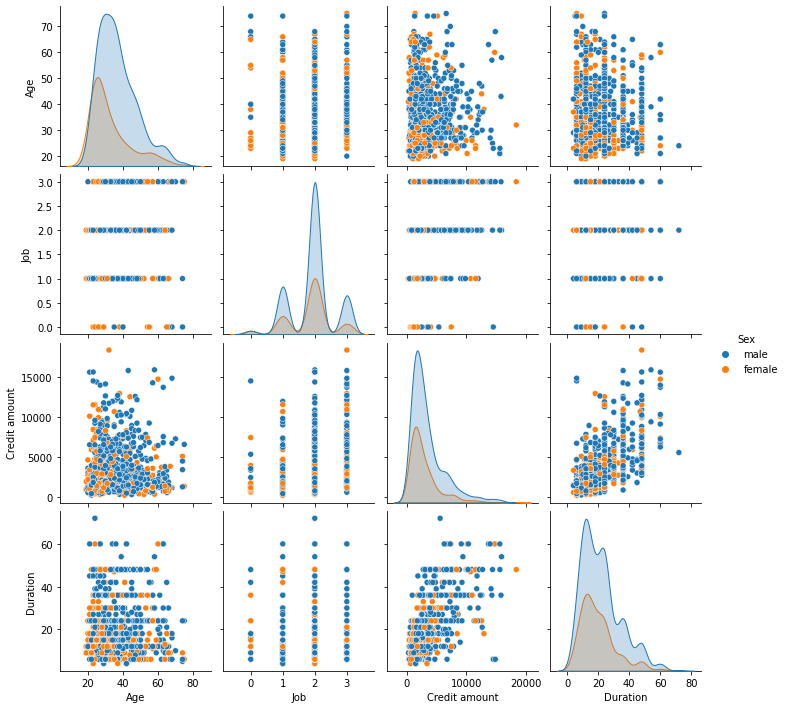

In [105]:
sns.pairplot(df,hue='Sex')

In [68]:
def plot(df, h=None, pal='deep'):
    sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=df, palette="Set1", aspect=2)
    sns.lmplot(x="Age",y="Credit amount", hue="Sex", data=df, palette="Set1", aspect=2)
    sns.lmplot(x="Age",y="Duration", hue="Sex", data=df, palette="Set1", aspect=2)


    plt.tight_layout()

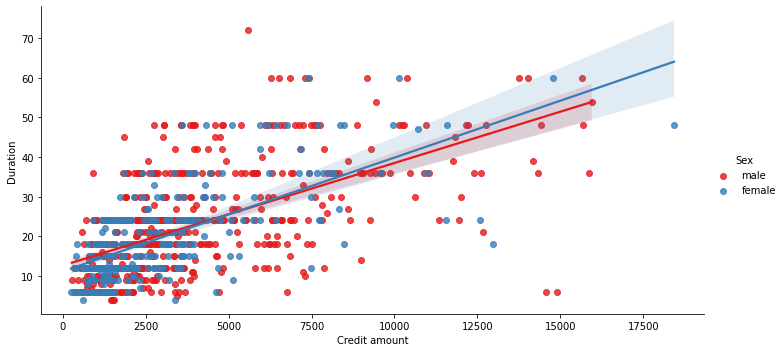

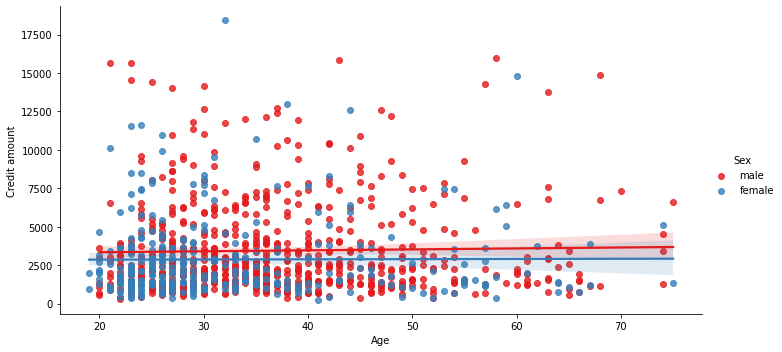

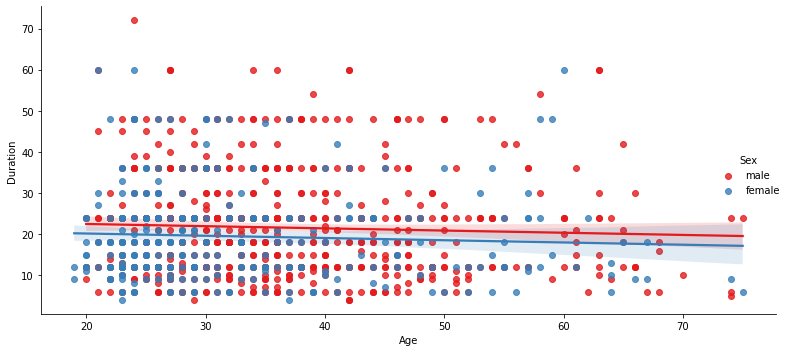

In [69]:
plot(df)

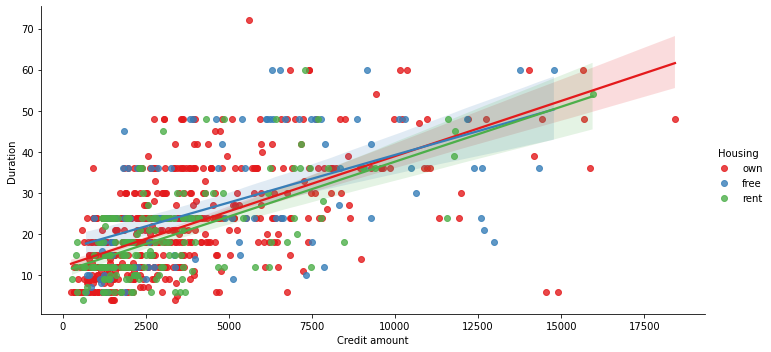

In [72]:
#it's evident that credit amount and duration has positive correlation but there is no significant differences based on gender. 

#Trying to explore it more as possible.


sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=df, palette="Set1", aspect=2)


In [99]:
purpose = df.groupby("Purpose")["Age"].count().rename("Count Value").reset_index()
purpose.sort_values(by=["Count Value"], ascending=False, inplace=True)

purpose

,Purpose,Count Value
1,car,337
5,radio/TV,280
4,furniture/equipment,181
0,business,97
3,education,59
6,repairs,22
2,domestic appliances,12
7,vacation/others,12


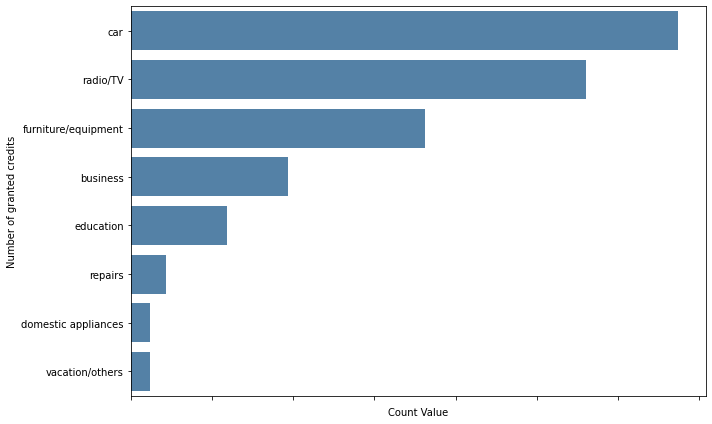

In [163]:
from ssl import Purpose
plt.figure(figsize=(10,6))
bar = sns.barplot(x="Count Value",y="Purpose",data=purpose,color='steelblue')
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

In [93]:
|def box(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=df)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

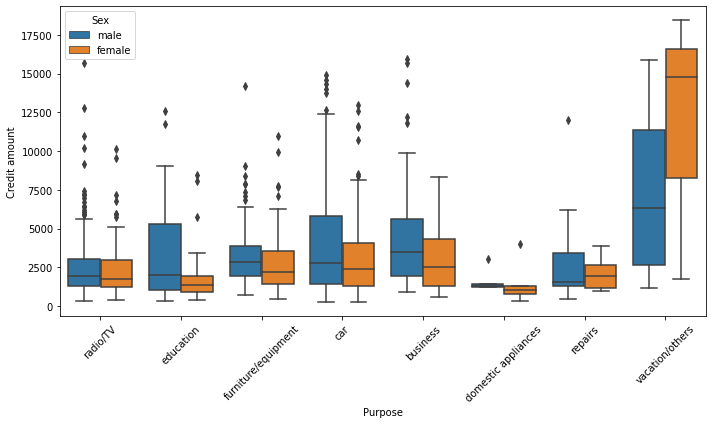

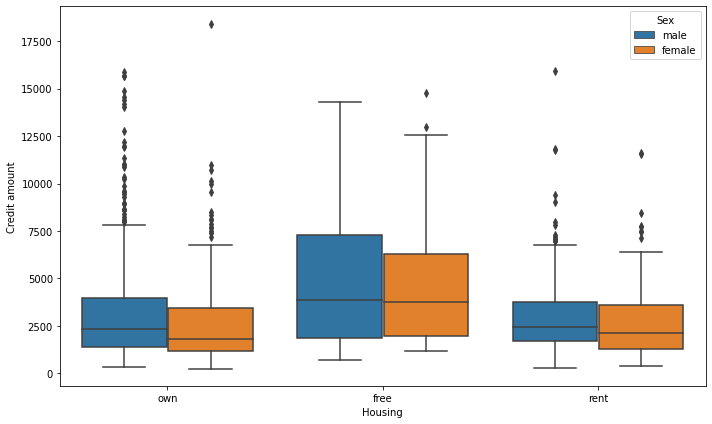

In [94]:
box("Purpose","Credit amount","Sex")
box("Housing","Credit amount","Sex",r=0)


In [107]:
#finding the mean values of our variables

df.groupby(['Sex'])['Credit amount','Duration','Age'].mean()

,Credit amount,Duration,Age
Sex,,,
female,2877.774194,19.43871,32.803226
male,3448.040580,21.56087,36.778261


In [109]:
df.corr()

,Age,Job,Credit amount,Duration
Age,1.000000,0.015673,0.032716,-0.036136
Job,0.015673,1.000000,0.285385,0.210910
Credit amount,0.032716,0.285385,1.000000,0.624984
Duration,-0.036136,0.210910,0.624984,1.000000


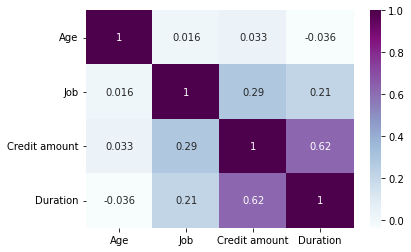

In [110]:
sns.heatmap(df.corr(),annot=True,cmap='BuPu')

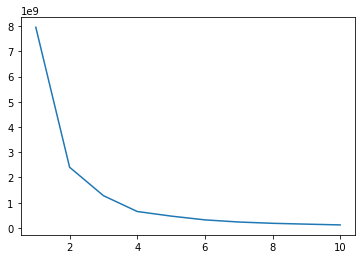

In [118]:
#elbow method to identify the numbe of clusters

int1=[]
for i in range(1,11):
  kmeans=KMeans(n_clusters=i)
  kmeans.fit(df[['Credit amount','Duration']])
  int1.append(kmeans.inertia_)
plt.plot(range(1,11),int1)


In [124]:
sel = ["Age","Credit amount", "Duration"]
cluster_data = df.loc[:,sel]

In [125]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

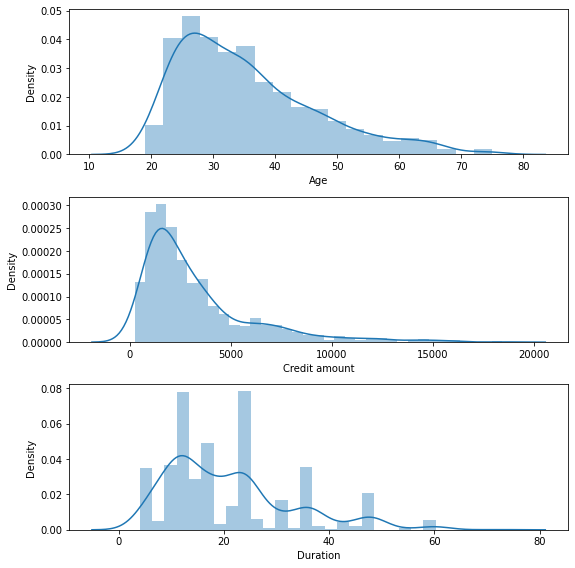

In [126]:
distributions(cluster_data)


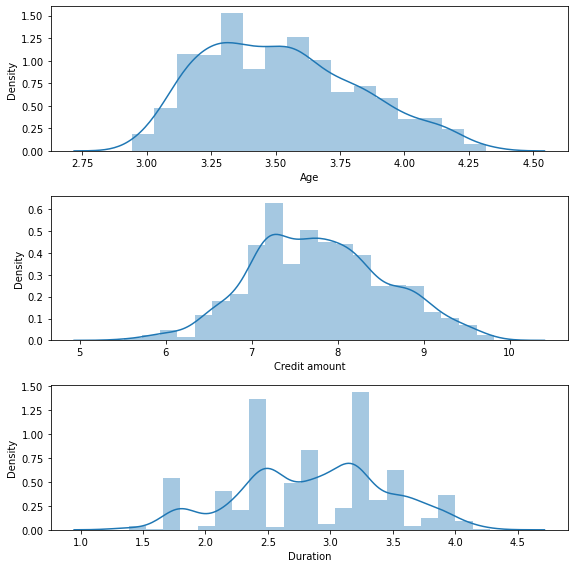

In [127]:
#making clear skewness

cluster_log = np.log(cluster_data)
distributions(cluster_log)

In [129]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

In [133]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

In [137]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

In [139]:
clustered_data

,Age,Credit amount,Duration,Cluster
0,67,1169,6,0
1,22,5951,48,1
2,49,2096,12,0
3,45,7882,42,1
4,53,4870,24,1
...,...,...,...,...
995,31,1736,12,2
996,40,3857,30,1
997,38,804,12,0
998,23,1845,45,1


In [147]:
clustered_data['Cluster'] = np.where((clustered_data.Cluster =='0'), 'First Group', clustered_data.Cluster)
clustered_data['Cluster'] = np.where((clustered_data.Cluster =='1'), 'Second Group', clustered_data.Cluster)
clustered_data['Cluster'] = np.where((clustered_data.Cluster =='2'), 'Thrid Group', clustered_data.Cluster)





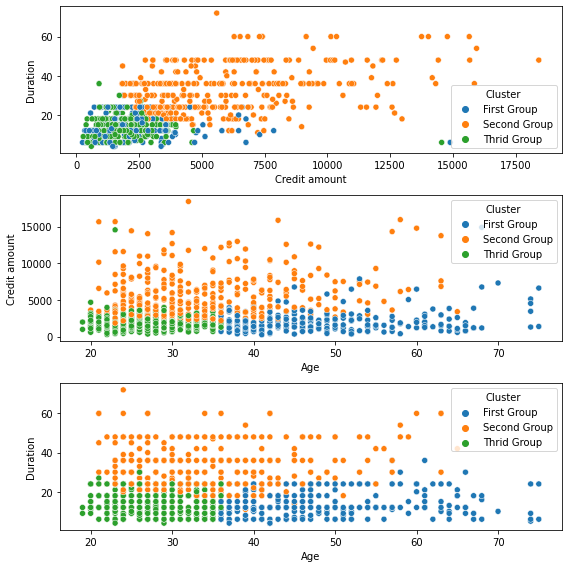

In [146]:
scatters(clustered_data,'Cluster')



In [148]:
Collective = clustered_data.groupby(['Cluster']).mean().round(1)
Collective

,Age,Credit amount,Duration
Cluster,,,
First Group,48.5,1970.3,13.9
Second Group,34.0,5665.4,32.2
Thrid Group,27.7,1736.3,14.3
